In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py
import sys
import os
import glob
import warnings
import matplotlib.pyplot as plt

from tqdm import tqdm

basedir = '/project/vitelli/jonathan/REDO_fruitfly/'
sys.path.insert(0, os.path.join(basedir, 'src'))

warnings.filterwarnings('ignore')

# Closed Loop integration of learned PINN model

(31, 236, 200) (31, 2, 2, 236, 200) (31, 2, 236, 200)


Text(0.5, 0, 'Time since VF initiation (min)')

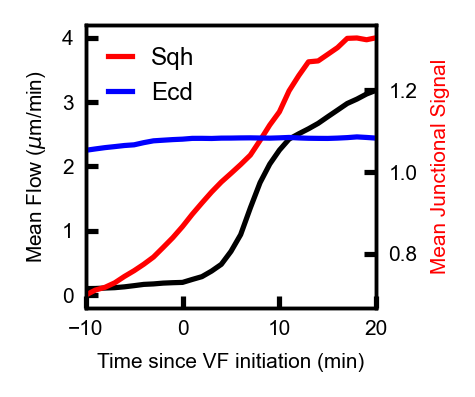

In [106]:
loaddir = '../Public/WT/ECad-GFP/ensemble/'
cad = np.load(os.path.join(loaddir, 'raw2D.npy'), mmap_mode='r')

loaddir = '../Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP/ensemble/'
t = np.load(os.path.join(loaddir, 't.npy'), mmap_mode='r')
mask = (t >= -10) & (t <= 20)
t = t[mask]

sqh = np.load(os.path.join(loaddir, 'tensor2D.npy'), mmap_mode='r')[mask]
vel = np.load(os.path.join(loaddir, 'velocity2D.npy'), mmap_mode='r')[mask]
y = np.load(os.path.join(loaddir, 'DV_coordinates.npy'), mmap_mode='r')
x = np.load(os.path.join(loaddir, 'AP_coordinates.npy'), mmap_mode='r')

cad = gaussian_filter(cad[mask], sigma=(0, 7, 7))
#cad = 0.5 * (cad + cad[:, ::-1])
              
print(cad.shape, sqh.shape, vel.shape)

plt.rcParams['font.size'] = 6
fig, ax = plt.subplots(1, 1, dpi=250, figsize=(1.5, 1.5))
ax2 = ax.twinx()
ax.plot(t, np.linalg.norm(vel, axis=1).mean(axis=(1, 2)), 
        color='black', label='Vel')
ax2.plot(t, np.linalg.norm(sqh, axis=(1, 2)).mean(axis=(1, 2)) * 1e1, 
         color='red', label='Sqh')
ax2.plot(t, cad.mean(axis=(1, 2)), 
         color='blue', label='Ecd')
ax2.legend(framealpha=0)

ax.set_ylim([-0.2, 4.2])
ax.set_xlim([-10, 20])
#ax2.set_yticks([80, 100, 120])
ax.set_yticks([0, 1, 2, 3, 4])

ax.set_ylabel('Mean Flow ($\\mu$m/min)')
ax2.set_ylabel('Mean Junctional Signal', color='red')
ax.set_xlabel('Time since VF initiation (min)')

Starting integration
Initializing
Using torchdiffeq solver


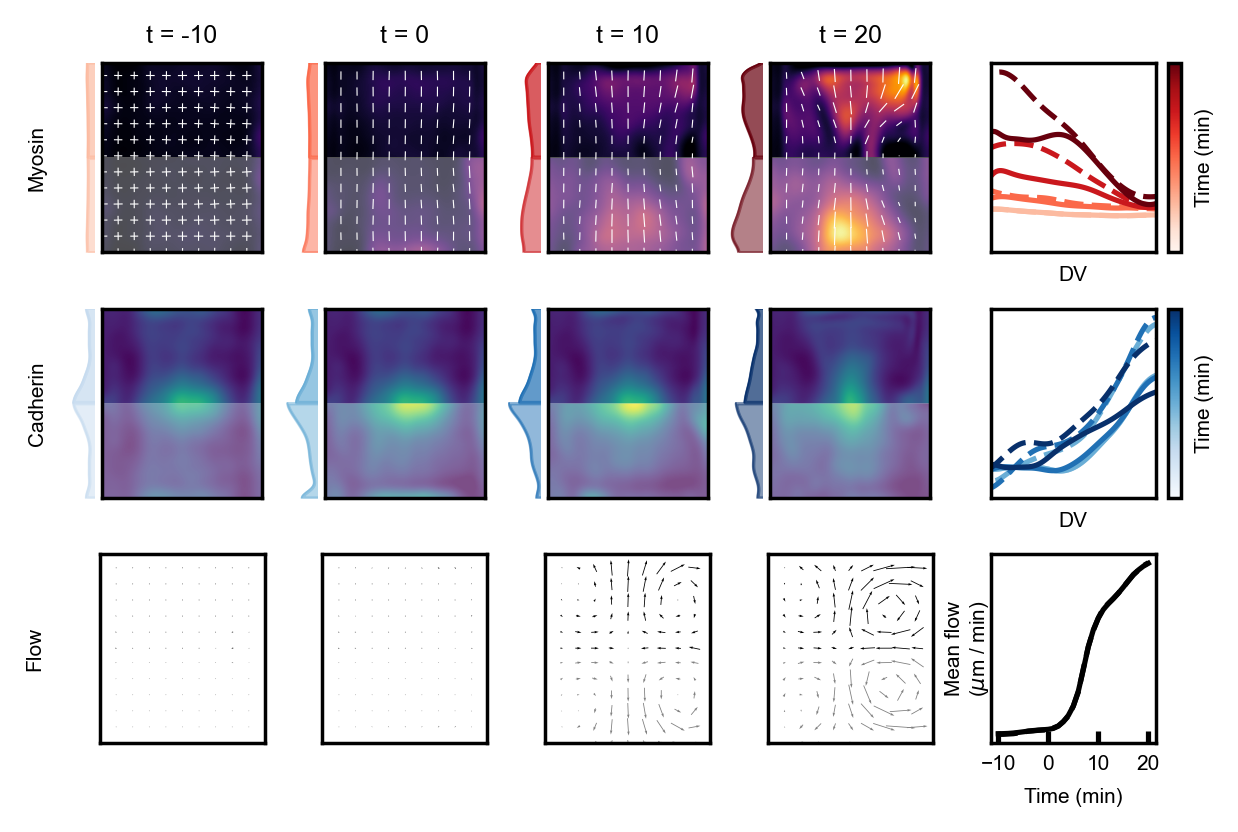

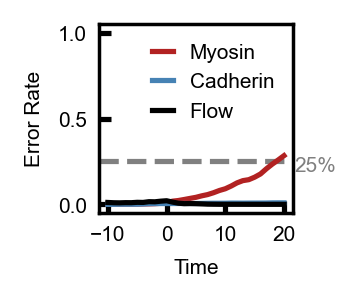

In [147]:
from run_MyosinDynamicsPINN import *
from closed_loop import ClosedPINNLoop
from utils.forecasting.plot_utils import *

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

dirs = './version_6_10_2023/'
beta=1e1
model = PositiveCoefficientsPINN
load_path = os.path.join(dirs, f'{model.__name__}_beta={beta:.0e}.ckpt')

y0 = torch.from_numpy(np.concatenate([
    sqh[0].reshape([4, *sqh.shape[-2:]]),
    cad[0].reshape([1, *cad.shape[-2:]]),
]))  
model = ClosedPINNLoop(model, load_path, sigma=3)
model.fit(y0[None])

print('Starting integration')
m, c, v = model.integrate(y0.to(device), t)

fig1, fig2 = comparison_plot(
    t,
    ('Myosin', m, sqh),
    ('Cadherin', c, cad),
    ('Flow', v, vel),
    dt=10)